In [54]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [57]:
def turnaroundTimePool(data_dir , algo, metric, folders =3, exp_no =[1,11], q_values = np.linspace(20, 200, num=19, dtype=int)):
    # finding optimum time quantum, pool version 
    x_values =[]
    y_values = []
    x_averages = []
    y_averages = []

    for q in q_values:

        values = [] # used to calculate average per q

        for f in range(folders):
            for exp in range(exp_no[0],exp_no[1]):

                array = np.genfromtxt(data_dir+f"data_{f}/{algo} q{q}_{metric}_{exp}.txt", delimiter=', ', dtype=float)
                values.extend(array[1:])
                x_values.extend([q] * len(array[1:]))
        
        y_values.extend(values)
        x_averages.append(q)
        y_averages.append(np.mean(values))
    
    return x_values, y_values, x_averages, y_averages

def plot_q(x_values, y_values, x_averages, y_averages):
    min_index = np.argmin(y_averages)
    x_min = x_averages[min_index]
    y_min = y_averages[min_index]

    plt.scatter(x = x_values, y = y_values, s=1, color='#87ceeb')
    #plt.annotate(f"Min\n({x_min}, {y_min:.2f})", xy=(x_min, y_min),xytext=(x_min + 0.5, y_min - 5),arrowprops=dict(arrowstyle='->', color='black'))
    plt.plot(x_averages, y_averages, color='#000080', marker='o', markersize=3, linestyle='-', label="Average per q")
    plt.plot(x_min, y_min, '*', color="#ff7f50",markersize=15, label=f"Min = ({x_min}, {y_min:.2f})")
    plt.title("Turnaround Time versus Time Quantum")  
    plt.xlabel("Time Quantum")
    plt.ylabel("Turnaround Time (ms)")
    plt.ylim(0, 15000)
    plt.legend()
    plt.show()


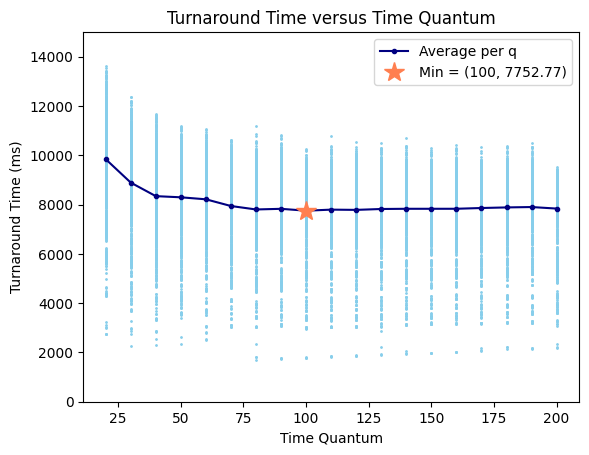

In [58]:
data_dir = "../graph_data/q_data/"
x, y, x_averages, y_averages =  turnaroundTimePool(data_dir,algo = "RR", metric = "turnaround time")

plot_q(x, y, x_averages, y_averages)

In [59]:

def extract_c_or_t(filename):
    data = [] 
    array = np.genfromtxt(filename, delimiter=", ", dtype=str)
    start_time = int(array[1].split(": ")[1])
    end_time = int(array[2].split(": ")[1])

    for i in range(3, 33):
        data.append( int(array[i]))
    #array = np.loadtxt(filename, delimiter=None, dtype=str)
    # print(len(data))
    # print(data)
    return start_time, end_time, data

def calc_cpu_util(fn):
    start_time, end_time, cpu_intervals = extract_c_or_t(fn)
    program_len = end_time - start_time
    cpu_ut = 0

    for i in cpu_intervals:
        cpu_ut += i
        
    return cpu_ut*100/program_len

def cpuu_per_folder(data_dir , algo, exp_no =[0,30], q = 100):
    # finding optimum time quantum, pool version 
    metric = "cpu utilization"
    cpu_util = []

    for exp in range(exp_no[0],exp_no[1]):
        cpu_util.append(calc_cpu_util(data_dir+f"{algo} q{q}_{metric}_{exp}.txt"))
    
    return cpu_util

def cpuu_pool(data_dir , algo, exp_no =[0,30], q = 100):
    cpu_util = []
    for folder in range (6):
        cpu_util.extend(cpuu_per_folder(data_dir+f"data_{folder}/" , algo, exp_no))
    
    return cpu_util

def hist_line(values):
    counts, bin_edges = np.histogram(values, bins=np.linspace(80, 100, 41))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    mean = np.mean(values)
    median = np.median(values)

    from scipy.interpolate import interp1d
    interp = interp1d(bin_centers, counts, kind='linear', fill_value="extrapolate")
    mean_y = interp(mean)
    median_y = interp(median)

    return bin_centers, counts, mean,mean_y, median, median_y

def plot_cpuu(valuesFCFS, valuesSJF, valuesRR):
    l = len(valuesFCFS)

    x_valuesF, y_valuesF, meanF, meanF_y, medianF, medianF_y = hist_line(valuesFCFS)
    x_valuesS, y_valuesS, meanS, meanS_y, medianS, medianS_y = hist_line(valuesSJF)
    x_valuesR, y_valuesR, meanR, meanR_y, medianR, medianR_y = hist_line(valuesRR)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(x_valuesF, y_valuesF, linestyle='-', marker='o', markersize= 2, color= "#87CEEB", label = "FCFS")
    plt.plot(x_valuesS, y_valuesS, linestyle='-', marker='o', markersize= 2, color= "#4682B4", label= "SJF")
    plt.plot(x_valuesR, y_valuesR, linestyle='-', marker='o', markersize= 2, color= "#191970", label = "RR")

    plt.scatter(medianS, medianS_y, color='#DC143C',marker = "*", s=30, label=f'SJF Median: {medianS:.2f}', zorder=3) 
    plt.scatter(meanS, meanS_y, color='#DC143C', marker = "x", s=20, label=f'SJF Mean: {meanS:.2f}', zorder=3)
    

    plt.scatter(medianF, medianF_y, color='#191970',marker = "*", s=30, label=f'FCFS Median: {medianF:.2f}', zorder=3) 
    plt.scatter(meanF, meanF_y, color='#191970', marker = "x", s=20, label=f'FCFS Mean: {meanF:.2f}', zorder=3)


    plt.scatter(medianR, medianR_y, color='#fc8d62',marker = "*", s=30, label=f'RR Median: {medianR:.2f}', zorder=3) 
    plt.scatter(meanR, meanR_y, color='#fc8d62', marker = "x", s=20, label=f'RR Mean: {meanR:.2f}', zorder=3)

    # plt.hist(values, bins=np.linspace(80, 100, 41), edgecolor='black')
    plt.xticks(np.arange(1, 101, 1))
    plt.ylim(0, 85)
    plt.xlim(80,100)
    plt.title(f'Distribution of CPU Utilisation for FCFS, SJF, and RR (n = {l})')
    plt.xlabel('CPU Utilization per Run (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


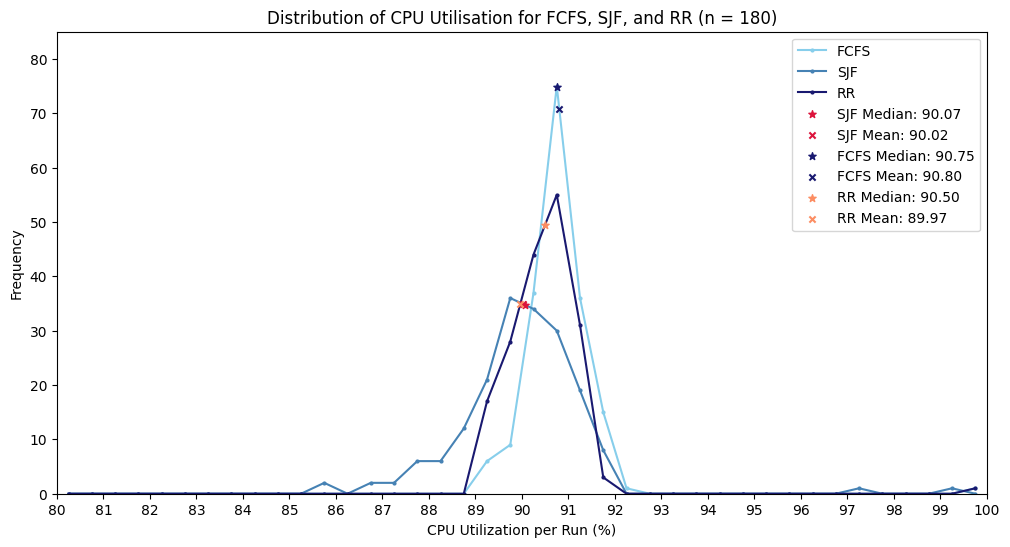

In [60]:
data_dir = "../graph_data/algo_2/"
plot_cpuu(cpuu_pool(data_dir, "FCFS"), cpuu_pool(data_dir, "SJF"), cpuu_pool(data_dir, "RR"))


In [61]:

def calculate_three_window_throughput(start_time, end_time, timestamps, window_no = 3):
    duration = end_time - start_time
    window_size = duration / window_no

    throughput = []

    for i in range(window_no):
        window_start = start_time + i * window_size
        window_end = window_start + window_size

        count = sum(1 for t in timestamps if window_start <= t < window_end)
        throughput.append((i, count))

    return throughput

def throughput_pool(data_dir , algo, exp_no =[0,30], folders = 6, q = 100, window_size = 100, filter = True):
    metric = "throughput"
    overall_throughput = []
    for folder in range(folders):
        for exp in range(exp_no[0],exp_no[1]):
            start_time, end_time, process_end = extract_c_or_t(data_dir+f"data_{folder}/{algo} q{q}_{metric}_{exp}.txt")
            throughput = calculate_three_window_throughput(start_time, end_time,process_end, window_size)
            #throughput = calculate_throughput(process_end,start_time, end_time, window_size)
            overall_throughput.extend( throughput)
    x, y = average_counts_xy(overall_throughput, window_size)
    return x, y, overall_throughput

from collections import defaultdict

def average_counts_xy(pairs, total_windows=1000):
    """Takes a list of (window_index, count) tuples and returns:
    x = window indices
    y = average count per window index
    """
    total = defaultdict(int)
    freq = defaultdict(int)  # avoid naming this "count"

    for window_index, value in pairs:
        total[window_index] += value
        freq[window_index] += 1

    x = list(range(total_windows))
    y = [(total[i] / freq[i]) if freq[i] > 0 else 0 for i in x]
    return x, y


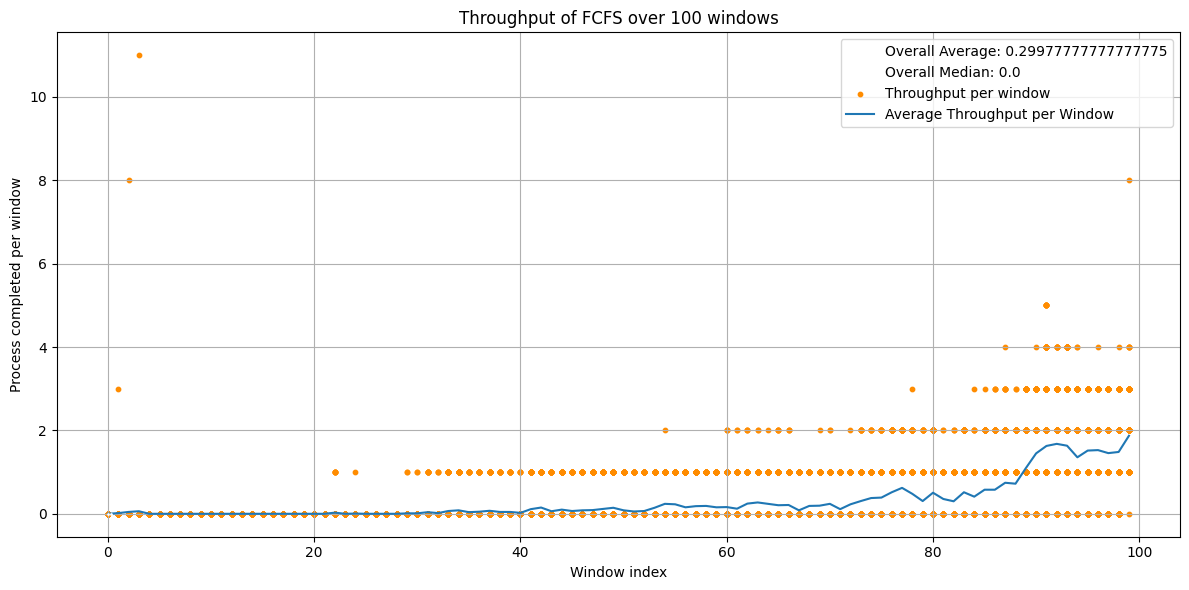

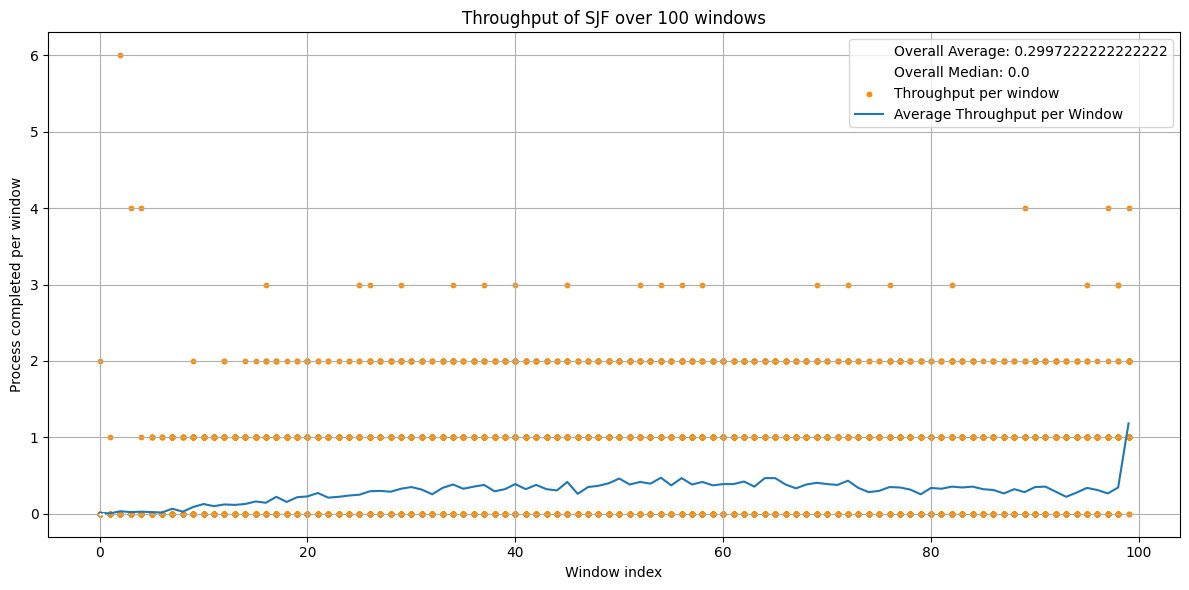

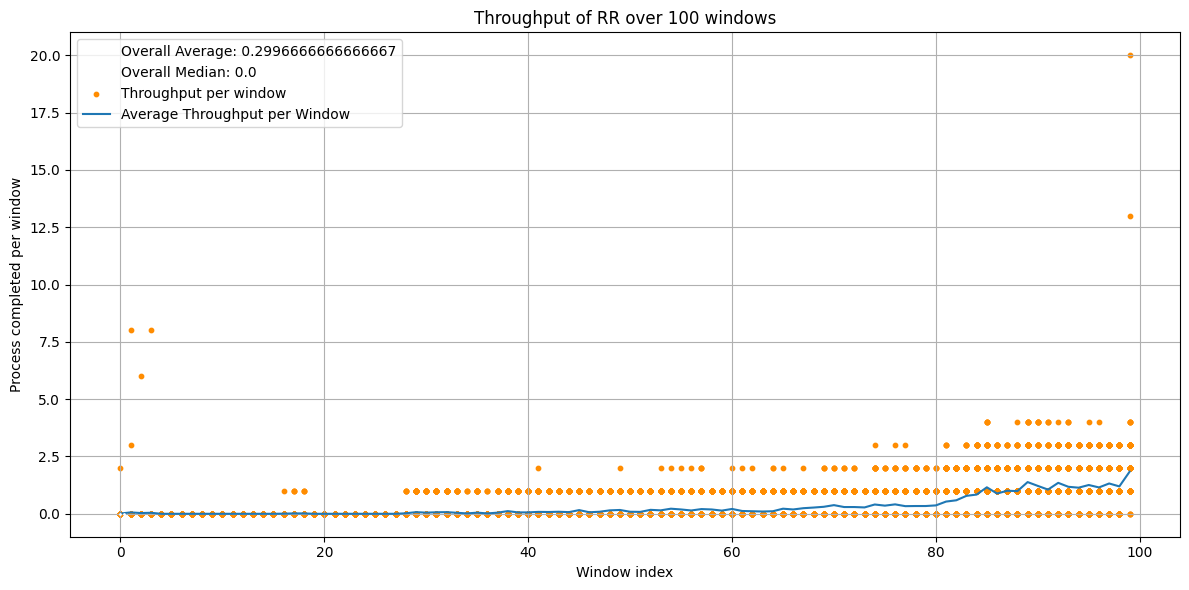

In [62]:
def plot_through(x,y,throughput_data, algo):
    x_values = [window_index for window_index, _ in throughput_data]  # relative time
    y_values = [count for _, count in throughput_data]


    avg = np.mean(y_values)
    median = np.median(y_values)

        # Find the index in y closest to avg and median
    avg_index = min(range(len(y_values)), key=lambda i: abs(y_values[i] - avg))
    median_index = min(range(len(y_values)), key=lambda i: abs(y_values[i] - median))

    plt.figure(figsize=(12, 6))
    plt.scatter(avg, avg_index, color='#FFFFFF', s=1, label=f'Overall Average: {avg}', zorder=5)
    plt.scatter(median, median_index, color='#FFFFFF', s=1,label=f'Overall Median: {median}', zorder=5)

    plt.scatter(x_values, y_values, color='darkorange', s=10, label='Throughput per window')
    plt.plot(x,y, label = "Average Throughput per Window")

    plt.xlabel("Window index")
    plt.ylabel("Process completed per window")
    plt.title(f"Throughput of {algo} over 100 windows")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

dir = "../graph_data/algo_2/"
x,y,throughput_data = throughput_pool(dir, "FCFS")
plot_through(x,y,throughput_data,"FCFS" )
x,y,throughput_data = throughput_pool(dir, "SJF")
plot_through(x,y,throughput_data, "SJF")
x,y,throughput_data = throughput_pool(dir, "RR")
plot_through(x,y,throughput_data, "RR")

In [63]:
def time_pool(data_dir , algo, metric,  exp_no =[0,30], folders = 6, q = 100, filter = True):
    values = np.array([])
    for exp in range(exp_no[0],exp_no[1]): # for each experiment, average the reps 
        for folder in range(folders):
            array = np.genfromtxt(data_dir+f"data_{folder}/{algo} q{q}_{metric}_{exp}.txt", delimiter=', ', dtype=float)
            values = np.append(values, array[1:])
        #print(values)
    
    values = values.flatten()# discard the heading value nan 
    filtered_data = values[(values <= 30000) ]
    
    if filter:
        return filtered_data
    return values

def hist_line(values, bin =50):
    counts, bin_edges = np.histogram(values, bins= bin)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    mean = np.mean(values)
    median = np.median(values)

    from scipy.interpolate import interp1d
    interp = interp1d(bin_centers, counts, kind='linear', fill_value="extrapolate")
    mean_y = interp(mean)
    median_y = interp(median)

    return bin_centers, counts, mean,mean_y, median, median_y


def hist_times(valuesFCFS, valuesSJF, valuesRR, metric):
    x_valuesF, y_valuesF, meanF, meanF_y, medianF, medianF_y = hist_line(valuesFCFS)
    x_valuesS, y_valuesS, meanS, meanS_y, medianS, medianS_y = hist_line(valuesSJF)
    x_valuesR, y_valuesR, meanR, meanR_y, medianR, medianR_y = hist_line(valuesRR)
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_valuesF, y_valuesF, linestyle='-', marker='o', markersize= 2, color= "#87CEEB", label = "FCFS")
    plt.plot(x_valuesS, y_valuesS, linestyle='-', marker='o', markersize= 2, color= "#4682B4", label= "SJF")
    plt.plot(x_valuesR, y_valuesR, linestyle='-', marker='o', markersize= 2, color= "#191970", label = "RR")

    plt.scatter(medianS, medianS_y, color='#DC143C',marker = "*", s=70, label=f'SJF Median: {medianS:.2f}', zorder=3) 
    plt.scatter(meanS, meanS_y, color='#DC143C', marker = "x", s=60, label=f'SJF Mean: {meanS:.2f}', zorder=3)
    

    plt.scatter(medianF, medianF_y, color='#191970',marker = "*", s=70, label=f'FCFS Median: {medianF:.2f}', zorder=3) 
    plt.scatter(meanF, meanF_y, color='#191970', marker = "x", s=60, label=f'FCFS Mean: {meanF:.2f}', zorder=3)


    plt.scatter(medianR, medianR_y, color='#fc8d62',marker = "*", s=70, label=f'RR Median: {medianR:.2f}', zorder=3) 
    plt.scatter(meanR, meanR_y, color='#fc8d62', marker = "x", s=60, label=f'RR Mean: {meanR:.2f}', zorder=3)

    # plt.hist(values, bins=np.linspace(80, 100, 41), edgecolor='black')
    
    plt.title(f'Distribution of {metric.title()} for FCFS, SJF, and RR')
    if metric == "response time":
        plt.ylim(0, 3100)
        plt.xlim(0,11000)
    else: 
        plt.ylim(0, 800)
        plt.xlim(0,15000)
    plt.xlabel(f'{ metric.title()}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

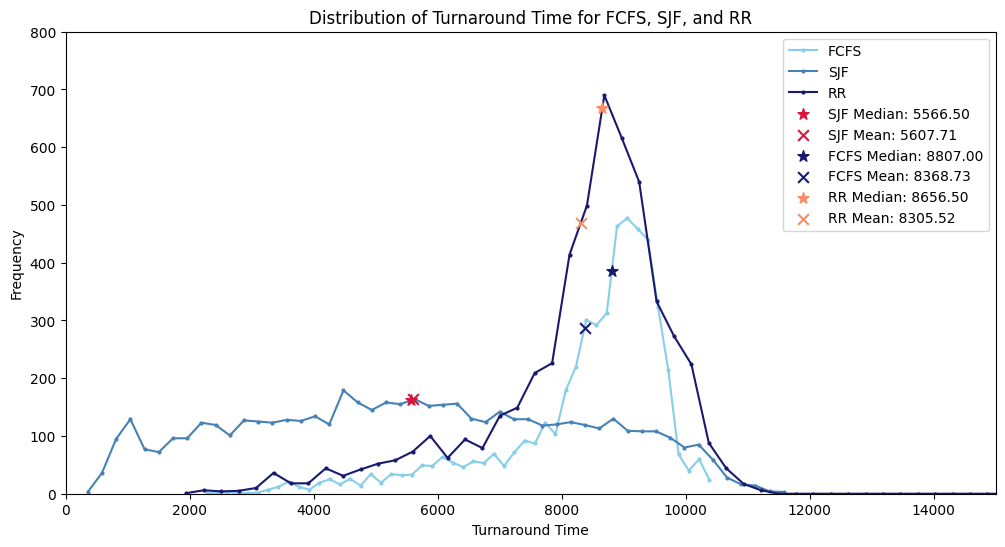

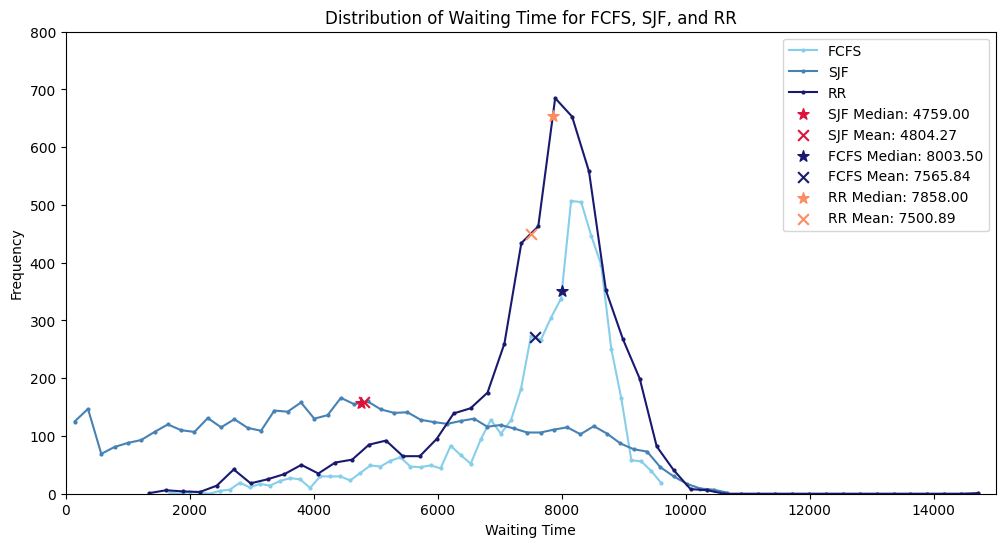

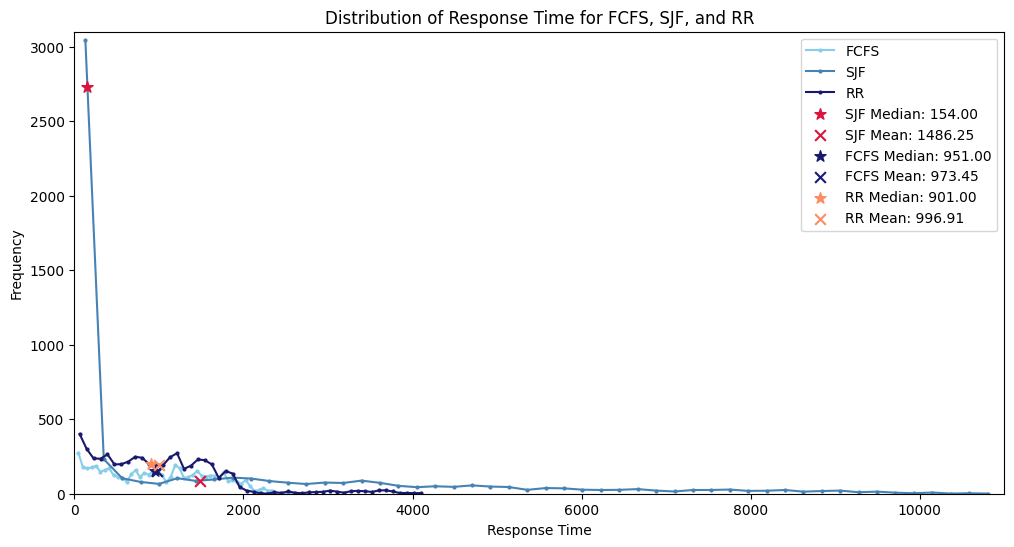

In [66]:
data_dir = "graph_data/algo/"
hist_times(time_pool(data_dir, "FCFS", "turnaround time"), time_pool(data_dir, "SJF","turnaround time"), time_pool(data_dir, "RR", "turnaround time"), "turnaround time")
hist_times(time_pool(data_dir, "FCFS", "waiting time"), time_pool(data_dir, "SJF","waiting time"), time_pool(data_dir, "RR", "waiting time"), "waiting time")
hist_times(time_pool(data_dir, "FCFS", "response time"), time_pool(data_dir, "SJF","response time"), time_pool(data_dir, "RR", "response time"), "response time")


In [ ]:
# print(time_pool(data_dir, "FCFS", "waiting time"))
# print(time_pool(data_dir, "SJF", "waiting time"))
# print(time_pool(data_dir, "RR", "waiting time"))